In [106]:
import pandas as pd 
import numpy as np
import os
from scipy import integrate, signal, fft, linalg

import matplotlib.pyplot as plt

# Parameters

In [107]:
source_path = r"C:\TRABAJO\CONICET\vibraciones edemsa\Procesamiento de los datos\ENSAYOS EDEMSA"

c_ini = 0
c_fin = 2

e_ini = 1
e_fin = 20

t_fin = 100

sampling_rate = 500  # samples per second

scale = 9.81  # accelaration in g


# window_size_t = 10.
fci = 1.  # Hz
fcs = 1.5*80.  # Hz

# Filtros

In [108]:
def remove_moving_mean(data, window_size=5):
    """
    Remove moving mean from the data using a sliding window.

    Parameters:
    - data: numpy array, the input data
    - window_size: int, size of the moving window

    Returns:
    - numpy array, data with moving mean removed
    """
    moving_mean = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    return data[window_size//2:-((window_size-1)//2)] - moving_mean


def filter_bw_nth(x, fci, fcs, fs, order=4):
    """
    Apply a nth order bandpass filter to signal x.

    Parameters:
        x (array_like): Input signal.
        fci (float): Lower cutoff frequency.
        fcs (float): Upper cutoff frequency.
        fs (float): Sampling frequency.

    Returns:
        array_like: Filtered signal.
    """
    nyq = 0.5 * fs
    low = fci / nyq
    high = fcs / nyq

    # Butterworth bandpass filter
    b, a = signal.butter(order, [low, high], btype='band')

    # Apply filter
    y = signal.lfilter(b, a, x)

    return y

# Read data

In [109]:
tests = {}

for e in range(e_ini, e_fin + 1):
    test_data = {}
    for c in range(c_ini, c_fin + 1):
        filenames = [f"C{c}E{e}", f"lc{c}E{e}", f"C{c}e{e}", f"c{c}e{e}"]
        for filename in filenames:
            try:
                c_data = np.array(pd.read_csv(os.path.join(source_path, filename), 
                                    skiprows=3, dtype='float')).reshape((-1,)) * scale
                break
            except FileNotFoundError:
                print('try next')
        
        a_data = filter_bw_nth(c_data, fci, fcs, sampling_rate)[500:]
        
        C_data = fft.fft(c_data)
        A_data = fft.fft(a_data)
        
        test_data.update({f'c{c}': c_data,
                          f'a{c}': a_data,
                          f'C{c}': C_data,
                          f'A{c}': A_data,})
    tests.update({f"e{e}": test_data})
    
descripciones = pd.read_csv('descripciones.txt', sep=':', header=None)
descripciones.columns = ['ensayo', 'descripción']
print(descripciones)

time_full = np.linspace(0, t_fin, tests[f'e{e_ini}'][f'c{c_ini}'].shape[0]).reshape((-1,))
freq_full = fft.fftfreq(c_data.shape[0], d=1/sampling_rate)
time_a = np.linspace(0, t_fin, tests[f'e{e_ini}'][f'a{c_ini}'].shape[0]).reshape((-1,))
freq_a = fft.fftfreq(a_data.shape[0], d=1/sampling_rate)
print(time_full.shape, freq_full.shape)

   ensayo                                        descripción
0      E1                                Subsuelo. A ciegas.
1      E2          Subsuelo. Metro-tranvía pasando de S a N.
2      E3   Subsuelo. Metro-tranvía pasando de N a S, con...
3      E4          Subsuelo. Metro-tranvía pasando de S a N.
4      E5         Subsuelo. Sin Metro-tranvía ni colectivos.
5      E6          Subsuelo. Metro-tranvía pasando de N a S.
6      E7                                5to piso. A ciegas.
7      E8          5to piso. Metro-tranvía pasando de N a S.
8      E9                 5to piso. Tres personas caminando.
9     E10   5to piso. Metro-tranvía pasando de S a N y un...
10    E11   5to piso. Metro-tranvía pasando de N a S y un...
11    E12   5to piso. Metro-tranvía pasando de S a N y un...
12    E13   5to piso. Colectivo pasando por Belgrano de S...
13    E14   5to piso en asiento de silla de oficina. Metr...
14    E15   5to piso en asiento de silla de oficina. Metr...
15    E16   5to piso en 

# Filter and integrate to get velocity

In [110]:
t_int_crop = 1 * sampling_rate

for e in tests.keys():
    test = tests[e]
    channels = test.keys()
    vels = {}
    for c in range(c_ini, c_fin + 1):
        integral = integrate.cumulative_trapezoid(y=tests[e][f'a{c}'], x=time_a, initial=0.)[t_int_crop:]
        v_data = integral - np.mean(integral)
        V_data = fft.fft(v_data)
        vels.update({f'v{c}': v_data,
                     f'V{c}': V_data})
    tests[e].update(vels)

time = time_a[t_int_crop:]
freq = fft.fftfreq(v_data.shape[0], d=1/sampling_rate)


In [111]:
tests[e].keys()

dict_keys(['c0', 'a0', 'C0', 'A0', 'c1', 'a1', 'C1', 'A1', 'c2', 'a2', 'C2', 'A2', 'v0', 'V0', 'v1', 'V1', 'v2', 'V2'])

# Plot!

In [112]:
# for e in range(e_ini, e_fin + 1):
#     fig_title = f'E{e}_tiempo'
#     fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 7))
#     fig.suptitle(fig_title)
#     for c in range(c_ini, c_fin + 1):
#         ax[0, c].plot(time_full, tests[f'e{e}'][f'c{c}'], label='crudo')
#         ax[0, c].plot(time_a, tests[f'e{e}'][f'a{c}'], label='filtrado')
#         ax[0, c].grid()
#         ax[1, c].plot(time, tests[f'e{e}'][f'v{c}'])
#         ax[1, c].set_xlabel('tiempo [s]')
#         ax[1, c].grid()
#     ax[0, c].legend()
#     ax[0, 0].set_ylabel(r'aceleración [$\mathrm{m/s^2}$]')
#     ax[1, 0].set_ylabel(r'velocidad [$\mathrm{m/s}$]')
#     fig.savefig(fig_title + '.pdf')

#     fig_title = f'E{e}_frecuencia'
#     fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 7))
#     fig.suptitle(fig_title)
#     for c in range(c_ini, c_fin + 1):
#         ax[0, c].plot(freq_full[0:freq_full.shape[0]//2], np.abs(tests[f'e{e}'][f'C{c}'][0:freq_full.shape[0]//2]), label='crudo')
#         ax[0, c].plot(freq_a[0:freq_a.shape[0]//2], np.abs(tests[f'e{e}'][f'A{c}'][0:freq_a.shape[0]//2]), label='filtrado')
#         ax[0, c].grid()
#         ax[0, c].set_ylim([0, max(np.abs(tests[f'e{e}'][f'A{c}']))])
#         ax[1, c].plot(freq[0:freq.shape[0]//2], np.abs(tests[f'e{e}'][f'V{c}'][0:freq.shape[0]//2]))
#         ax[1, c].set_xlabel('frecuencia [Hz]')
#         ax[1, c].grid()
#         ax[1, c].set_xlim([0, 250])
#     ax[0, c].legend()
#     ax[0, 0].set_ylabel(r'aceleración')
#     ax[1, 0].set_ylabel(r'velocidad')
#     fig.savefig(fig_title + '.pdf')

In [113]:
# e = 9


# xlim = (16.815, 16.825)
# fig, ax = plt.subplots(4, 2, sharex='col', sharey='col', figsize=(10, 20))
# for c in range(c_ini, c_fin + 1):
#     ax[c, 0].plot(time, tests[f'e{e}'][f'v{c}'])
#     ax[c, 1].plot(time, tests[f'e{e}'][f'v{c}'])
#     ax[c, 1].grid()
#     ax[c, 0].set_ylabel('velocidad (m/s)')

# vel_comp = np.sqrt(tests[f'e{e}'][f'v{0}']**2 + tests[f'e{e}'][f'v{1}']**2 + tests[f'e{e}'][f'v{2}']**2)
# ax[3, 0].plot(time, vel_comp)
# ax[3, 1].plot(time, vel_comp)
# ax[3, 1].set_xlim(xlim)
# ax[3, 0].set_ylabel('velocidad compuesta (m/s)')
# ax[3, 1].grid()


# fig, ax = plt.subplots(4, 2, sharex='col', sharey='col', figsize=(10, 20))
# for c in range(c_ini, c_fin + 1):
#     ax[c, 0].plot(time_a, tests[f'e{e}'][f'a{c}'])
#     ax[c, 1].plot(time_a, tests[f'e{e}'][f'a{c}'])
#     ax[c, 1].grid()
#     ax[c, 0].set_ylabel('aceleración (m/s^2)')

# vel_comp = np.sqrt(tests[f'e{e}'][f'a{0}']**2 + tests[f'e{e}'][f'a{1}']**2 + tests[f'e{e}'][f'a{2}']**2)
# ax[3, 0].plot(time_a, vel_comp)
# ax[3, 1].plot(time_a, vel_comp)
# ax[3, 1].set_xlim(xlim)
# ax[3, 1].grid()
# ax[3, 0].set_ylabel('aceleración compuesta (m/s^2)')

# Velocity summary

In [114]:
directions = ['EO', 'NS', 'vertical']
data_table = []
for e in range(e_ini, e_fin+1):
    e_data_table = []
    vel = np.sqrt(tests[f'e{e}'][f'v{0}']**2 + tests[f'e{e}'][f'v{1}']**2 + tests[f'e{e}'][f'v{2}']**2)
    e_data_table.append(linalg.norm(vel, np.inf))
    e_data_table.append(np.sqrt(np.mean(np.square(vel))))
    e_data_table.append(e_data_table[-2]/e_data_table[-1])
    e_data_table.append(linalg.norm(tests[f'e{e}'][f'v{0}'], np.inf))
    e_data_table.append(linalg.norm(tests[f'e{e}'][f'v{1}'], np.inf))
    e_data_table.append(linalg.norm(tests[f'e{e}'][f'v{2}'], np.inf))
    e_data_table.append(max(e_data_table[-3:]))
    e_data_table.append(directions[np.argmax(e_data_table[-4:-1])])
    data_table.append(e_data_table)

df_vel_SI = pd.DataFrame(data_table, columns=['pico', 'rms', 'factor_de_cresta', 'max_EO', 'max_NS', 'max_vertical', 'max', 'dir_max'],
                        index=[f'E{e}' for e in range(e_ini, e_fin+1)])
df_vel_mm_s = df_vel_SI.copy()
df_vel_mm_s.iloc[:, 0:2] = df_vel_mm_s.iloc[:, 0:2]*1000
df_vel_mm_s.iloc[:, 3:-1] = df_vel_mm_s.iloc[:, 3:-1]*1000
df_vel_mm_s = df_vel_mm_s.round(2)
df_vel_mm_s.columns = ['pico_mm_s', 'rms_mm_s', 'factor_de_cresta', 'max_EO_mm_s', 'max_NS_mm_s', 'max_vertical_mm_s', 'max_mm_s', 'dir_max']
df_vel_mm_s['ensayo'] = df_vel_mm_s.index
df_vel_mm_s.index = range(df_vel_mm_s.shape[0])
df_vel_mm_s['descripción'] = descripciones.iloc[:, 1]


df_vel_mm_s.to_excel('componente de velocidad en mm sobre s.xlsx')

In [115]:
df_vel_SI

,pico,rms,factor_de_cresta,max_EO,max_NS,max_vertical,max,dir_max
E1,0.000131,0.000026,5.033677,0.000080,0.000050,0.000129,0.000129,vertical
E2,0.000188,0.000033,5.756386,0.000112,0.000107,0.000154,0.000154,vertical
E3,0.000183,0.000026,7.110700,0.000165,0.000117,0.000128,0.000165,EO
E4,0.000266,0.000035,7.694296,0.000176,0.000142,0.000248,0.000248,vertical
E5,0.000111,0.000025,4.447580,0.000047,0.000040,0.000110,0.000110,vertical
E6,0.000166,0.000034,4.848080,0.000054,0.000063,0.000166,0.000166,vertical
E7,0.000554,0.000066,8.351471,0.000174,0.000512,0.000303,0.000512,NS
E8,0.000346,0.000064,5.386589,0.000177,0.000202,0.000342,0.000342,vertical
E9,0.002796,0.000076,36.614811,0.002795,0.000257,0.001300,0.002795,EO
E10,0.000434,0.000066,6.608335,0.000189,0.000305,0.000432,0.000432,vertical


In [116]:
df_vel_mm_s

,pico_mm_s,rms_mm_s,factor_de_cresta,max_EO_mm_s,max_NS_mm_s,max_vertical_mm_s,max_mm_s,dir_max,ensayo,descripción
0,0.13,0.03,5.03,0.08,0.05,0.13,0.13,vertical,E1,Subsuelo. A ciegas.
1,0.19,0.03,5.76,0.11,0.11,0.15,0.15,vertical,E2,Subsuelo. Metro-tranvía pasando de S a N.
2,0.18,0.03,7.11,0.16,0.12,0.13,0.16,EO,E3,"Subsuelo. Metro-tranvía pasando de N a S, con..."
3,0.27,0.03,7.69,0.18,0.14,0.25,0.25,vertical,E4,Subsuelo. Metro-tranvía pasando de S a N.
4,0.11,0.02,4.45,0.05,0.04,0.11,0.11,vertical,E5,Subsuelo. Sin Metro-tranvía ni colectivos.
5,0.17,0.03,4.85,0.05,0.06,0.17,0.17,vertical,E6,Subsuelo. Metro-tranvía pasando de N a S.
6,0.55,0.07,8.35,0.17,0.51,0.30,0.51,NS,E7,5to piso. A ciegas.
7,0.35,0.06,5.39,0.18,0.20,0.34,0.34,vertical,E8,5to piso. Metro-tranvía pasando de N a S.
8,2.80,0.08,36.61,2.79,0.26,1.30,2.79,EO,E9,5to piso. Tres personas caminando.
9,0.43,0.07,6.61,0.19,0.30,0.43,0.43,vertical,E10,5to piso. Metro-tranvía pasando de S a N y un...


In [117]:
df_vel_mm_s_max = df_vel_mm_s.drop(['pico_mm_s', 'rms_mm_s', 'factor_de_cresta'], axis=1)
df_vel_mm_s_max.to_excel('max componente de velocidad en mm sobre s.xlsx')
df_vel_mm_s_max

,max_EO_mm_s,max_NS_mm_s,max_vertical_mm_s,max_mm_s,dir_max,ensayo,descripción
0,0.08,0.05,0.13,0.13,vertical,E1,Subsuelo. A ciegas.
1,0.11,0.11,0.15,0.15,vertical,E2,Subsuelo. Metro-tranvía pasando de S a N.
2,0.16,0.12,0.13,0.16,EO,E3,"Subsuelo. Metro-tranvía pasando de N a S, con..."
3,0.18,0.14,0.25,0.25,vertical,E4,Subsuelo. Metro-tranvía pasando de S a N.
4,0.05,0.04,0.11,0.11,vertical,E5,Subsuelo. Sin Metro-tranvía ni colectivos.
5,0.05,0.06,0.17,0.17,vertical,E6,Subsuelo. Metro-tranvía pasando de N a S.
6,0.17,0.51,0.30,0.51,NS,E7,5to piso. A ciegas.
7,0.18,0.20,0.34,0.34,vertical,E8,5to piso. Metro-tranvía pasando de N a S.
8,2.79,0.26,1.30,2.79,EO,E9,5to piso. Tres personas caminando.
9,0.19,0.30,0.43,0.43,vertical,E10,5to piso. Metro-tranvía pasando de S a N y un...


# Acceleration summary

## Basic filters

In [118]:
def filter_lp_nth(x, fc, fs, order=2):
    """
    Apply a nth order lowpass filter to signal x.

    Parameters:
        x (array_like): Input signal.
        fc (float): cutoff frequency.
        fs (float): Sampling frequency.

    Returns:
        array_like: Filtered signal.
    """
    # Butterworth low pass filter
    b, a = signal.butter(order, fc, btype='low', analog=False, fs=fs)

    # Apply filter
    y = signal.lfilter(b, a, x)

    return y


def filter_hp_nth(x, fc, fs, order=2):
    """
    Apply a nth order highpass filter to signal x.

    Parameters:
        x (array_like): Input signal.
        fc (float): cutoff frequency.
        fs (float): Sampling frequency.

    Returns:
        array_like: Filtered signal.
    """

    # Butterworth high pass filter
    b, a = signal.butter(order, fc, btype='high', analog=False, fs=fs)

    # Apply filter
    y = signal.lfilter(b, a, x)

    return y

## Weightening filters

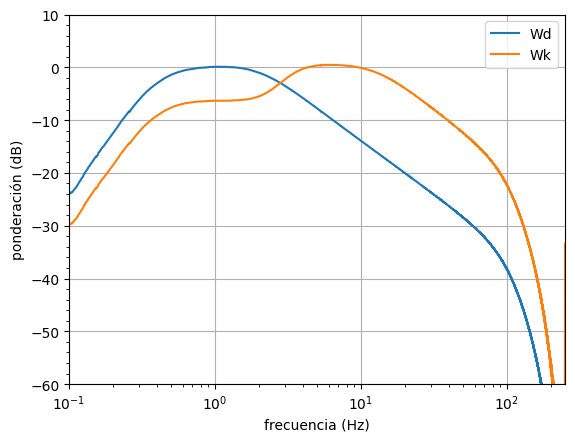

In [119]:
# Banda limitante, válido para Wk, Wd, We, Wj, Wc
def limit_band_filter(x, fs):
    x_lp = filter_lp_nth(x, 100, fs, 2)
    return filter_hp_nth(x_lp, 0.4, fs, 2)


class Filter_Ht_Hs:
    def __init__(self, fs, W):
        assert W in ['Wk', 'Wd'], NotImplementedError  # implemented transicion_aceleracion_velocidad and subida_de_escala
        self.W = W
        f3 = {  'Wk': 12.5,
                'Wd':  2.}
        f4 = {  'Wk': 12.5,
                'Wd':  2.}
        f5 = {  'Wk':  2.37,
                'Wd': np.inf}
        f6 = {  'Wk':  3.35,
                'Wd': np.inf}
        q4 = {  'Wk':  0.63,
                'Wd':  0.63}
        q5 = {  'Wk':  0.91,
                'Wd': None}
        q6 = {  'Wk':  0.91,
                'Wd': None}

        omega3 = 2*np.pi*f3[W]
        omega4 = 2*np.pi*f4[W]
        omega5 = 2*np.pi*f5[W]
        omega6 = 2*np.pi*f6[W]
        Q4 = q4[W]
        Q5 = q5[W]
        Q6 = q6[W]

        # Ht: transicion_aceleracion_velocidad
        Ht_numerator = [1/omega3, 1]  # Define the continuous-time transfer function coefficients
        Ht_denominator = [1/(omega4**2), 1/(Q4*omega4), 1]
        self.Ht_b, self.Ht_a = signal.bilinear(Ht_numerator, Ht_denominator, fs)  # Convert the continuous-time transfer function to discrete-time using bilinear transform

        # Hs: subida_de_escala
        if W == 'Wk':
            Hs_numerator = [((omega5/omega6)**2)*(1/(omega5**2)), ((omega5/omega6)**2)*(1/(omega5*Q5)), ((omega5/omega6)**2)*1]  # Define the continuous-time transfer function coefficients
            Hs_denominator = [(1/(omega6**2)), 1/(omega6*Q6), 1]
            self.Hs_b, self.Hs_a = signal.bilinear(Hs_numerator, Hs_denominator, fs)  # Convert the continuous-time transfer function to discrete-time using bilinear transform
        elif W == 'Wd':
            self.Hs_b, self.Hs_a = None, None
        else:
            raise NotImplementedError

    def apply_filter(self, x):
        x_Ht = signal.lfilter(self.Ht_b, self.Ht_a, x)
        if self.W == 'Wd':
            return x_Ht
        elif self.W == 'Wk':
            return signal.lfilter(self.Hs_b, self.Hs_a, x_Ht)
        else:
            raise NotImplementedError


class Weightening:
    def __init__(self, fs, W):
        assert W in ['Wk', 'Wd', 'We', 'Wj', 'Wc'], NotImplementedError  # implemented banda limitante
        assert W in ['Wk', 'Wd'], NotImplementedError  # implemented transicion_aceleracion_velocidad and subida_de_escala
        self.W = W
        self.fs = fs 

        if self.W in ['Wk', 'Wd', 'We', 'Wj', 'Wc']:
            self.filter_Hl_Hh = lambda x: limit_band_filter(x, fs)
        else:
            raise NotImplementedError

        self.filter_Ht_Hs = Filter_Ht_Hs(fs, W)

    def weigh(self, x):
        x_bl = self.filter_Hl_Hh(x)
        return self.filter_Ht_Hs.apply_filter(x_bl)


# Test
wk = Weightening(fs=sampling_rate, W='Wk')
wd = Weightening(fs=sampling_rate, W='Wd')

t_fin_test = 1000
time_full_ = np.linspace(0, t_fin_test, sampling_rate*t_fin_test)
a = np.random.standard_normal(time_full_.shape[0])
# a = np.sin(2*np.pi*1*time_full_)
a_lb = limit_band_filter(a, sampling_rate)
a_wd = wd.weigh(a)
a_wk = wk.weigh(a)

plt.minorticks_on()
# plt.plot(time_full_, a, label='a')
# plt.plot(time_full_, a_lb, label='lb')
# # plt.plot(time_full_, a_wd, label='Wd')
# # plt.plot(time_full_, a_wk, label='Wk')
# plt.xlim((0,10))
# plt.legend()
# plt.show()

A = fft.fft(a)[:len(a)//2]
A_lb = fft.fft(a_lb)[:len(a)//2]
A_wd = fft.fft(a_wd)[:len(a)//2]
A_wk = fft.fft(a_wk)[:len(a)//2]
A_freq = fft.fftfreq(a.shape[0], d=1/sampling_rate)[:len(a)//2]

# plt.plot(A_freq, np.abs(A))
# plt.plot(A_freq, np.abs(A_w))
# # plt.xlim((0, 50))

# plt.show()

# plt.plot(A_freq, 20*np.log10(np.abs(A_lb)/np.abs(A)), label='lb')
# plt.plot(A_freq, 20*np.log10(np.abs(A_wd)/np.abs(A)), label='Wd')
# plt.plot(A_freq, 20*np.log10(np.abs(A_wk)/np.abs(A)), label='Wk')
# plt.plot(A_freq, np.convolve(np.ones(100)/100., 20*np.log10(np.abs(A_lb)/np.abs(A)), mode='same'), label='lb')
plt.plot(A_freq, np.convolve(np.ones(100)/100., 20*np.log10(np.abs(A_wd)/np.abs(A)), mode='same'), label='Wd')
plt.plot(A_freq, np.convolve(np.ones(100)/100., 20*np.log10(np.abs(A_wk)/np.abs(A)), mode='same'), label='Wk')
plt.xlabel('frecuencia (Hz)')
plt.ylabel('ponderación (dB)')
plt.legend()
plt.xscale('log')
plt.grid()
plt.xlim((0.1, 250))
plt.ylim((-60, 10))
plt.savefig('ponderación.pdf')
plt.show()


## Test clasification and weightening filters

In [120]:
ensayos_de_pie = ['e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'e10', 'e11', 'e12', 'e13', 'e17', 'e18', 'e19', 'e20']
ensayos_sentadas = ['e14', 'e15', 'e16']

wd = Weightening(fs=sampling_rate, W='Wd')
wk = Weightening(fs=sampling_rate, W='Wd')

column_names = ['ensayo', 
                'ax_rms', 'ay_rms', 'az_rms', 
                'ax_Wd_rms', 'ay_Wd_rms', 'az_Wk_rms', 
                'ax_Wd_fc',  'ay_Wd_fc',  'az_Wk_fc', 
                'a_W_rms_total']

column_names_adicional = [
    'ensayo', 
    'ax_Wd_mtvv', 'ay_Wd_mtvv', 'az_Wk_mtvv', 
    'a_W_mtvv_total']


def rms(x):
    return np.sqrt(np.mean(np.square(x)))

def peak(x):
    return np.max(np.abs(x))

def moving_rms(x, window_length):
    y = []
    for i in range(len(x)-window_length):
        y.append(rms(x[i:i+window_length]))
    return y

## Salud

### Personas de pie (Nota en pie de la página 21 de IRAM 4078-1* del 2020)

In [121]:
# Ponderaciones según norma IRAM 4078-1* del 2020

# eje x (vibración del suelo): W = Wd, kx=1.4
# eje y (vibración del suelo): W = Wd, ky=1.4
# eje z (vibración del suelo): W = Wk, kz=1

kx = 1.4
ky = 1.4
kz = 1

#### Básico

In [122]:
a_rms_salud_depie_basico = []
for e in ensayos_de_pie:
    ax_rms = rms(tests[e]['a0'])
    ay_rms = rms(tests[e]['a1'])
    az_rms = rms(tests[e]['a2'])
    ax_Wd_rms = rms(wd.weigh(tests[e]['a0']))
    ay_Wd_rms = rms(wd.weigh(tests[e]['a1']))
    az_Wk_rms = rms(wk.weigh(tests[e]['a2']))
    ax_Wd_fc = peak(wd.weigh(tests[e]['a0']))/ax_Wd_rms
    ay_Wd_fc = peak(wd.weigh(tests[e]['a1']))/ay_Wd_rms
    az_Wk_fc = peak(wk.weigh(tests[e]['a2']))/az_Wk_rms
    a_W_rms_total = np.sqrt((ax_Wd_rms*kx)**2 + (ay_Wd_rms*ky)**2 + (az_Wk_rms*kz)**2)
    a_rms_salud_depie_basico.append([e.upper(), 
                              ax_rms, ay_rms, az_rms, 
                              ax_Wd_rms, ay_Wd_rms, az_Wk_rms, 
                              ax_Wd_fc, ay_Wd_fc, az_Wk_fc, 
                              a_W_rms_total])

df_a_rms_salud_depie_basico = pd.DataFrame(a_rms_salud_depie_basico, columns=column_names)
df_a_rms_salud_depie_basico.to_excel('a_rms_salud_depie_basico.xlsx')
df_a_rms_salud_depie_basico

,ensayo,ax_rms,ay_rms,az_rms,ax_Wd_rms,ay_Wd_rms,az_Wk_rms,ax_Wd_fc,ay_Wd_fc,az_Wk_fc,a_W_rms_total
0,E1,0.000872,0.000907,0.001512,0.000129,0.000105,0.000297,6.603510,6.492402,11.334649,0.000377
1,E2,0.001333,0.001447,0.002531,0.000129,0.000112,0.000315,6.941081,8.609550,5.754432,0.000395
2,E3,0.001270,0.001314,0.001712,0.000148,0.000133,0.000250,14.592447,9.260564,8.856511,0.000375
3,E4,0.001746,0.001667,0.002962,0.000161,0.000197,0.000373,12.751667,8.714957,8.155180,0.000516
4,E5,0.000754,0.000806,0.001679,0.000097,0.000096,0.000307,5.849118,5.550029,10.913595,0.000361
5,E6,0.000980,0.001040,0.001972,0.000104,0.000116,0.000391,6.355722,6.293894,9.110769,0.000448
6,E7,0.001878,0.003159,0.006598,0.000298,0.000390,0.000614,7.219054,15.605701,5.899294,0.000922
7,E8,0.001648,0.002492,0.005665,0.000294,0.000421,0.000570,7.217226,11.327817,7.468207,0.000917
8,E9,0.004912,0.002098,0.005677,0.000499,0.000333,0.000645,63.416537,7.866339,22.459343,0.001059
9,E10,0.001672,0.002640,0.006406,0.000272,0.000367,0.000640,8.191350,8.608775,8.155802,0.000905


#### Adicional

In [123]:
tau = 1  # s
a_rms_salud_depie_adicional = []
for e in ensayos_de_pie:
    ax_Wd_mtvv = peak(moving_rms(wd.weigh(tests[e]['a0']), tau*sampling_rate))
    ay_Wd_mtvv = peak(moving_rms(wd.weigh(tests[e]['a1']), tau*sampling_rate))
    az_Wk_mtvv = peak(moving_rms(wk.weigh(tests[e]['a2']), tau*sampling_rate))
    a_W_mtvv_total = np.sqrt((ax_Wd_mtvv*kx)**2 + (ay_Wd_mtvv*ky)**2 + (az_Wk_mtvv*kz)**2)
    a_rms_salud_depie_adicional.append([e.upper(), 
                                        ax_Wd_mtvv, ay_Wd_mtvv, az_Wk_mtvv, 
                                        a_W_mtvv_total])

df_a_rms_salud_depie_adicional = pd.DataFrame(a_rms_salud_depie_adicional, columns=column_names_adicional)
df_a_rms_salud_depie_adicional.to_excel('a_rms_salud_depie_adicional.xlsx')
df_a_rms_salud_depie_adicional

,ensayo,ax_Wd_mtvv,ay_Wd_mtvv,az_Wk_mtvv,a_W_mtvv_total
0,E1,0.000450,0.000285,0.001877,0.002020
1,E2,0.000374,0.000306,0.000888,0.001116
2,E3,0.000542,0.000490,0.001413,0.001744
3,E4,0.000553,0.000851,0.001810,0.002301
4,E5,0.000182,0.000216,0.001979,0.002018
5,E6,0.000221,0.000373,0.002044,0.002132
6,E7,0.000641,0.001168,0.000971,0.002103
7,E8,0.000751,0.001374,0.001797,0.002835
8,E9,0.004389,0.000721,0.002548,0.006729
9,E10,0.000842,0.000861,0.002066,0.002667


### Personas sentadas

In [124]:
# Ponderaciones según norma IRAM 4078-1* del 2020

# eje x (vibración del asiento): W = Wd, kx=1.4
# eje y (vibración del asiento): W = Wd, ky=1.4
# eje z (vibración del asiento): W = Wk, kz=1

kx = 1.4
ky = 1.4
kz = 1

#### Básico

In [125]:
a_rms_salud_sentadas_basico = []
for e in ensayos_sentadas:
    ax_rms = rms(tests[e]['a0'])
    ay_rms = rms(tests[e]['a1'])
    az_rms = rms(tests[e]['a2'])
    ax_Wd_rms = rms(wd.weigh(tests[e]['a0']))
    ay_Wd_rms = rms(wd.weigh(tests[e]['a1']))
    az_Wk_rms = rms(wk.weigh(tests[e]['a2']))
    ax_Wd_fc = peak(wd.weigh(tests[e]['a0']))/ax_Wd_rms
    ay_Wd_fc = peak(wd.weigh(tests[e]['a1']))/ay_Wd_rms
    az_Wk_fc = peak(wk.weigh(tests[e]['a2']))/az_Wk_rms
    a_W_rms_total = np.sqrt((ax_Wd_rms*kx)**2 + (ay_Wd_rms*ky)**2 + (az_Wk_rms*kz)**2)
    a_rms_salud_sentadas_basico.append([e.upper(), 
                              ax_rms, ay_rms, az_rms, 
                              ax_Wd_rms, ay_Wd_rms, az_Wk_rms, 
                              ax_Wd_fc, ay_Wd_fc, az_Wk_fc, 
                              a_W_rms_total])

df_a_rms_salud_sentadas_basico = pd.DataFrame(a_rms_salud_sentadas_basico, columns=column_names)
df_a_rms_salud_sentadas_basico.to_excel('a_rms_salud_sentadas_basico.xlsx')
df_a_rms_salud_sentadas_basico

,ensayo,ax_rms,ay_rms,az_rms,ax_Wd_rms,ay_Wd_rms,az_Wk_rms,ax_Wd_fc,ay_Wd_fc,az_Wk_fc,a_W_rms_total
0,E14,0.007133,0.016735,0.034400,0.002698,0.003948,0.027318,6.725299,5.679577,12.802338,0.028126
1,E15,0.009514,0.020056,0.044092,0.003712,0.007093,0.035011,7.728665,12.041900,9.643971,0.036761
2,E16,0.009458,0.013350,0.064037,0.004241,0.004616,0.049139,6.931572,6.709973,9.019054,0.049916


#### Adicional

In [126]:
tau = 1  # s
a_rms_salud_sentadas_adicional = []
for e in ensayos_sentadas:
    ax_Wd_mtvv = peak(moving_rms(wd.weigh(tests[e]['a0']), tau*sampling_rate))
    ay_Wd_mtvv = peak(moving_rms(wd.weigh(tests[e]['a1']), tau*sampling_rate))
    az_Wk_mtvv = peak(moving_rms(wk.weigh(tests[e]['a2']), tau*sampling_rate))
    a_W_mtvv_total = np.sqrt((ax_Wd_mtvv*kx)**2 + (ay_Wd_mtvv*ky)**2 + (az_Wk_mtvv*kz)**2)
    a_rms_salud_sentadas_adicional.append([e.upper(), 
                                        ax_Wd_mtvv, ay_Wd_mtvv, az_Wk_mtvv, 
                                        a_W_mtvv_total])

df_a_rms_salud_sentadas_adicional = pd.DataFrame(a_rms_salud_sentadas_adicional, columns=column_names_adicional)
df_a_rms_salud_sentadas_adicional.to_excel('a_rms_salud_sentadas_adicional.xlsx')
df_a_rms_salud_sentadas_adicional

,ensayo,ax_Wd_mtvv,ay_Wd_mtvv,az_Wk_mtvv,a_W_mtvv_total
0,E14,0.008498,0.011196,0.186352,0.187388
1,E15,0.014913,0.043742,0.183206,0.194295
2,E16,0.013633,0.013694,0.241691,0.243200


## Bienestar y percepción

### Personas de pie

In [127]:
# Ponderaciones según norma IRAM 4078-1* del 2020

# eje x (vibración del suelo): W = Wd, kx=1
# eje y (vibración del suelo): W = Wd, ky=1
# eje z (vibración del suelo): W = Wk, kz=1


kx = 1.
ky = 1.
kz = 1.

#### Básico

In [128]:
a_rms_bienestarypercepcion_depie_basico = []
for e in ensayos_de_pie:
    ax_rms = rms(tests[e]['a0'])
    ay_rms = rms(tests[e]['a1'])
    az_rms = rms(tests[e]['a2'])
    ax_Wd_rms = rms(wd.weigh(tests[e]['a0']))
    ay_Wd_rms = rms(wd.weigh(tests[e]['a1']))
    az_Wk_rms = rms(wk.weigh(tests[e]['a2']))
    ax_Wd_fc = peak(wd.weigh(tests[e]['a0']))/ax_Wd_rms
    ay_Wd_fc = peak(wd.weigh(tests[e]['a1']))/ay_Wd_rms
    az_Wk_fc = peak(wk.weigh(tests[e]['a2']))/az_Wk_rms
    a_W_rms_total = np.sqrt((ax_Wd_rms*kx)**2 + (ay_Wd_rms*ky)**2 + (az_Wk_rms*kz)**2)
    a_rms_bienestarypercepcion_depie_basico.append([e.upper(), 
                              ax_rms, ay_rms, az_rms, 
                              ax_Wd_rms, ay_Wd_rms, az_Wk_rms, 
                              ax_Wd_fc, ay_Wd_fc, az_Wk_fc, 
                              a_W_rms_total])

df_a_rms_bienestarypercepcion_depie_basico = pd.DataFrame(a_rms_bienestarypercepcion_depie_basico, columns=column_names)
df_a_rms_bienestarypercepcion_depie_basico.to_excel('a_rms_bienestarypercepcion_depie_basico.xlsx')
df_a_rms_bienestarypercepcion_depie_basico


,ensayo,ax_rms,ay_rms,az_rms,ax_Wd_rms,ay_Wd_rms,az_Wk_rms,ax_Wd_fc,ay_Wd_fc,az_Wk_fc,a_W_rms_total
0,E1,0.000872,0.000907,0.001512,0.000129,0.000105,0.000297,6.603510,6.492402,11.334649,0.000340
1,E2,0.001333,0.001447,0.002531,0.000129,0.000112,0.000315,6.941081,8.609550,5.754432,0.000358
2,E3,0.001270,0.001314,0.001712,0.000148,0.000133,0.000250,14.592447,9.260564,8.856511,0.000320
3,E4,0.001746,0.001667,0.002962,0.000161,0.000197,0.000373,12.751667,8.714957,8.155180,0.000452
4,E5,0.000754,0.000806,0.001679,0.000097,0.000096,0.000307,5.849118,5.550029,10.913595,0.000335
5,E6,0.000980,0.001040,0.001972,0.000104,0.000116,0.000391,6.355722,6.293894,9.110769,0.000421
6,E7,0.001878,0.003159,0.006598,0.000298,0.000390,0.000614,7.219054,15.605701,5.899294,0.000786
7,E8,0.001648,0.002492,0.005665,0.000294,0.000421,0.000570,7.217226,11.327817,7.468207,0.000767
8,E9,0.004912,0.002098,0.005677,0.000499,0.000333,0.000645,63.416537,7.866339,22.459343,0.000881
9,E10,0.001672,0.002640,0.006406,0.000272,0.000367,0.000640,8.191350,8.608775,8.155802,0.000787


#### Adicional

In [129]:
tau = 1  # s
a_rms_bienestarypercepcion_depie_adicional = []
for e in ensayos_de_pie:
    ax_Wd_mtvv = peak(moving_rms(wd.weigh(tests[e]['a0']), tau*sampling_rate))
    ay_Wd_mtvv = peak(moving_rms(wd.weigh(tests[e]['a1']), tau*sampling_rate))
    az_Wk_mtvv = peak(moving_rms(wk.weigh(tests[e]['a2']), tau*sampling_rate))
    a_W_mtvv_total = np.sqrt((ax_Wd_mtvv*kx)**2 + (ay_Wd_mtvv*ky)**2 + (az_Wk_mtvv*kz)**2)
    a_rms_bienestarypercepcion_depie_adicional.append([e.upper(), 
                                        ax_Wd_mtvv, ay_Wd_mtvv, az_Wk_mtvv, 
                                        a_W_mtvv_total])

df_a_rms_bienestarypercepcion_depie_adicional = pd.DataFrame(a_rms_bienestarypercepcion_depie_adicional, columns=column_names_adicional)
df_a_rms_bienestarypercepcion_depie_adicional.to_excel('a_rms_bienestarypercepcion_depie_adicional.xlsx')
df_a_rms_bienestarypercepcion_depie_adicional

,ensayo,ax_Wd_mtvv,ay_Wd_mtvv,az_Wk_mtvv,a_W_mtvv_total
0,E1,0.000450,0.000285,0.001877,0.001951
1,E2,0.000374,0.000306,0.000888,0.001011
2,E3,0.000542,0.000490,0.001413,0.001590
3,E4,0.000553,0.000851,0.001810,0.002075
4,E5,0.000182,0.000216,0.001979,0.001999
5,E6,0.000221,0.000373,0.002044,0.002090
6,E7,0.000641,0.001168,0.000971,0.001649
7,E8,0.000751,0.001374,0.001797,0.002384
8,E9,0.004389,0.000721,0.002548,0.005126
9,E10,0.000842,0.000861,0.002066,0.002391


### Personas sentadas

In [130]:
# Ponderaciones según norma IRAM 4078-1* del 2020

# eje x (vibración del asiento): W = Wd, kx=1
# eje y (vibración del asiento): W = Wd, ky=1
# eje z (vibración del asiento): W = Wk, kz=1


kx = 1.
ky = 1.
kz = 1.

#### Básico

In [131]:
a_rms_bienestarypercepcion_sentadas_basico = []
for e in ensayos_sentadas:
    ax_rms = rms(tests[e]['a0'])
    ay_rms = rms(tests[e]['a1'])
    az_rms = rms(tests[e]['a2'])
    ax_Wd_rms = rms(wd.weigh(tests[e]['a0']))
    ay_Wd_rms = rms(wd.weigh(tests[e]['a1']))
    az_Wk_rms = rms(wk.weigh(tests[e]['a2']))
    ax_Wd_fc = peak(wd.weigh(tests[e]['a0']))/ax_Wd_rms
    ay_Wd_fc = peak(wd.weigh(tests[e]['a1']))/ay_Wd_rms
    az_Wk_fc = peak(wk.weigh(tests[e]['a2']))/az_Wk_rms
    a_W_rms_total = np.sqrt((ax_Wd_rms*kx)**2 + (ay_Wd_rms*ky)**2 + (az_Wk_rms*kz)**2)
    a_rms_bienestarypercepcion_sentadas_basico.append([e.upper(), 
                              ax_rms, ay_rms, az_rms, 
                              ax_Wd_rms, ay_Wd_rms, az_Wk_rms, 
                              ax_Wd_fc, ay_Wd_fc, az_Wk_fc, 
                              a_W_rms_total])

df_a_rms_bienestarypercepcion_sentadas_basico = pd.DataFrame(a_rms_bienestarypercepcion_sentadas_basico, columns=column_names)
df_a_rms_bienestarypercepcion_sentadas_basico.to_excel('a_rms_bienestarypercepcion_sentadas_basico.xlsx')
df_a_rms_bienestarypercepcion_sentadas_basico


,ensayo,ax_rms,ay_rms,az_rms,ax_Wd_rms,ay_Wd_rms,az_Wk_rms,ax_Wd_fc,ay_Wd_fc,az_Wk_fc,a_W_rms_total
0,E14,0.007133,0.016735,0.034400,0.002698,0.003948,0.027318,6.725299,5.679577,12.802338,0.027733
1,E15,0.009514,0.020056,0.044092,0.003712,0.007093,0.035011,7.728665,12.041900,9.643971,0.035914
2,E16,0.009458,0.013350,0.064037,0.004241,0.004616,0.049139,6.931572,6.709973,9.019054,0.049537


#### Adicional

In [132]:
tau = 1  # s
a_rms_bienestarypercepcion_sentadas_adicional = []
for e in ensayos_sentadas:
    ax_Wd_mtvv = peak(moving_rms(wd.weigh(tests[e]['a0']), tau*sampling_rate))
    ay_Wd_mtvv = peak(moving_rms(wd.weigh(tests[e]['a1']), tau*sampling_rate))
    az_Wk_mtvv = peak(moving_rms(wk.weigh(tests[e]['a2']), tau*sampling_rate))
    a_W_mtvv_total = np.sqrt((ax_Wd_mtvv*kx)**2 + (ay_Wd_mtvv*ky)**2 + (az_Wk_mtvv*kz)**2)
    a_rms_bienestarypercepcion_sentadas_adicional.append([e.upper(), 
                                        ax_Wd_mtvv, ay_Wd_mtvv, az_Wk_mtvv, 
                                        a_W_mtvv_total])

df_a_rms_bienestarypercepcion_sentadas_adicional = pd.DataFrame(a_rms_bienestarypercepcion_sentadas_adicional, columns=column_names_adicional)
df_a_rms_bienestarypercepcion_sentadas_adicional.to_excel('a_rms_bienestarypercepcion_sentadas_adicional.xlsx')
df_a_rms_bienestarypercepcion_sentadas_adicional

,ensayo,ax_Wd_mtvv,ay_Wd_mtvv,az_Wk_mtvv,a_W_mtvv_total
0,E14,0.008498,0.011196,0.186352,0.186881
1,E15,0.014913,0.043742,0.183206,0.188945
2,E16,0.013633,0.013694,0.241691,0.242462
